In [5]:
# IMPORTANDO BIBLIOTECAS E CLONANDO REPOSITÓRIO DE IMAGENS
import pandas as pd
import numpy as np
import cv2
import os
# import matplotlib.pyplot as plt
import scipy as sp
import skimage
from scipy import signal
from skimage import transform
import imageio
from skimage import io, transform, util, filters
from skimage.util import montage
from skimage import data, exposure, img_as_float
from scipy.ndimage import convolve
# from google.colab import files
import xml.etree.ElementTree as ET
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

# !git clone https://github.com/lucasnardivieira/fruitsDB.git

In [6]:
classNames=['apple', 'banana', 'lemon', 'strawberry', 'tangerine']

In [8]:
# LENDO E EXIBINDO METADATA
metaData = pd.read_csv("metadata.csv", index_col = False)
metaData

,ID,Fruit Name,Size,Backgroud,Format
0,0,Apple,6016x4512,Black/White,png
1,1,Banana,6016x4512,Black/White,png
2,2,Lemon,6016x4512,Black/White,png
3,3,Strawberry,6016x4512,Black/White,png
4,4,Tangerine,6016x4512,Black/White,png


In [10]:
# DATA ANNOTATION
# Arquivo xml criado com a ferramenta https://app.cvat.ai/tasks
def read_xml_file(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    return root

def process_annotations(root):
    images = []
    for image_elem in root.findall('.//image'):
        image_id = int(image_elem.attrib['id'])
        image_name = image_elem.attrib['name']
        boxes = []
        for box_elem in image_elem.findall('.//box'):
            label = box_elem.attrib['label']
            xtl = float(box_elem.attrib['xtl'])
            ytl = float(box_elem.attrib['ytl'])
            xbr = float(box_elem.attrib['xbr'])
            ybr = float(box_elem.attrib['ybr'])
            boxes.append({'label': label, 'xtl': xtl, 'ytl': ytl, 'xbr': xbr, 'ybr': ybr})
        images.append({'id': image_id, 'name': image_name, 'boxes': boxes})

    return images

xml_file = 'annotations.xml'
root = read_xml_file(xml_file)
annotations = process_annotations(root)

In [36]:
# FUNÇÃO QUE EXIBE IMAGENS
def display_images(images, classe):
    image_folder = "fruitsDB/original_pictures/" + classe.lower()
    classe = classe.lower()
    for image_info in images:
        if image_info['boxes'][0]['label'] == classe:
            image_path = f"{image_folder}/{image_info['name']}"
            image = cv2.imread(image_path)
            for box_info in image_info['boxes']:
                xtl, ytl, xbr, ybr = map(int, [box_info['xtl'], box_info['ytl'], box_info['xbr'], box_info['ybr']])
                label = box_info['label']
                color = (0, 255, 0) # Green color for bounding boxes
                thickness = 10
                cv2.rectangle(image, (xtl, ybr), (xbr, ytl), color, thickness)
                cv2.putText(image, label, (xtl, ytl - 5), cv2.FONT_HERSHEY_SIMPLEX, 5, color, thickness)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title(f"Image: {image_info['name']}")
            plt.show()

In [ ]:
display_images(annotations,"STRAWBERRY")

In [ ]:
display_images(annotations,"APPLE")

In [ ]:
display_images(annotations,"BANANA")

In [10]:
display_images(annotations,"TANGERINE")

In [11]:
display_images(annotations,"LEMON")

In [39]:
# FUNÇÃO QUE MOSTRA UMA GRADE DE IMAGENS
def printImages(directory, name, row, col):
    directory_path = directory
    directory_files = os.listdir(directory_path)
    directory_files.sort()

    images = []
    for file in directory_files:
        img = io.imread(os.path.join(directory_path, file))
        img_resized = transform.resize(img, (600, 800), anti_aliasing=False)
        images.append(img_resized)

    if not images:
        print("No images found in the directory.")
        return

    montage = util.montage(images, fill=(0, 0, 0), grid_shape=(row, col), channel_axis=3)

    plt.imshow(montage)
    plt.title(name)
    plt.axis("off")

    return images

In [ ]:
bananaList = printImages("fruitsDB/original_pictures/banana", "banana", 4, 5)

In [ ]:
tangerineList = printImages("fruitsDB/original_pictures/tangerine", "tangerine", 4, 5)

In [ ]:
lemonList = printImages("fruitsDB/original_pictures/lemon", "lemon", 4, 5)

In [ ]:
strawberryList = printImages("fruitsDB/original_pictures/strawberry", "strawberry", 4, 5)

In [ ]:
appleList = printImages("fruitsDB/original_pictures/apple", "apple", 4, 5)

# Data augmentation

In [16]:
# DATA AUGMENTATION
# As imagens já estçao salvas no GITHUB
def dataAugmentation(directory, name):
    directory_path = directory
    directory_files = os.listdir(directory_path)
    directory_files.sort()
    
    # Cria o diretório com o nome da variável 'name', se não existir
    output_dir = os.path.join(directory_path, name)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for file in directory_files:
        img = io.imread(os.path.join(directory_path, file))

        img_resize = transform.resize(img, (600, 800), anti_aliasing=False)
        img_gamma = exposure.adjust_gamma(img_resize, gamma=2, gain=1)
        img_log = exposure.adjust_log(img_resize, gain=1, inv=False)
        img_mean = filters.threshold_local(img_resize, block_size=3, method='mean', offset=0, param=None, cval=0)

        images = [(img_resize, "resize"), (img_gamma, "gamma"), (img_log, "log"), (img_mean, "mean")]

        for img_processed, filename_suffix in images:
            img_float32 = np.float32(img_processed)
            filename = filename_suffix + "-" + file
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, cv2.cvtColor(img_float32 * 255, cv2.COLOR_RGB2BGR))
            

In [17]:
dataAugmentation("original_pictures/apple", "apple")

In [19]:
dataAugmentation("original_pictures/banana", "banana")
dataAugmentation("original_pictures/tangerine", "tangerine")
dataAugmentation("original_pictures/lemon", "lemon")
dataAugmentation("original_pictures/strawberry", "strawberry")

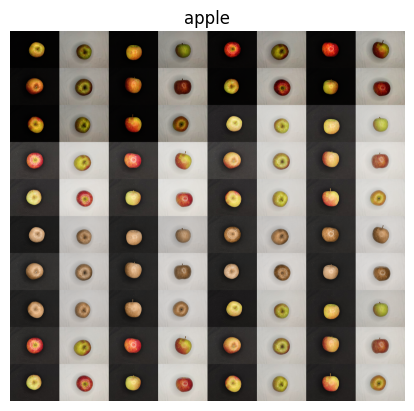

In [ ]:
appleListAugmentation = printImages("fruitsDB/dataAugmentation/apple", "apple", 10, 8)


In [ ]:
bananaListAugmentation = printImages("fruitsDB/dataAugmentation/banana", "banana", 10, 8)
tangerineListAugmentation = printImages("fruitsDB/dataAugmentation/tangerine", "tangerine", 10, 8)
lemonListAugmentation = printImages("fruitsDB/dataAugmentation/lemon", "lemon", 10, 8)
strawberryListAugmentation = printImages("fruitsDB/dataAugmentation/strawberry", "strawberry", 10, 8)

In [58]:
# NORMALIZATION
# RESOLVER ESTA FUNÇÃO, NÃO ESTÁ SENDO CHAMADA #
def normalization(image):
    img_clipped = np.clip(image, 0, 1)
    newImage = (img_clipped * 255).astype(np.uint8)
    return newImage

In [61]:
def saveLocal(images, folder):
    save_dir = f'{folder}/'
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    for i in range(len(images)):
        filename = f'{save_dir}img{i}.png'
        image_normalized = cv2.normalize(images[i], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        image_rgb = cv2.cvtColor(image_normalized, cv2.COLOR_BGR2RGB)
        cv2.imwrite(filename, image_rgb)

In [66]:
def equalization(directory):
    directory_path = directory
    directory_files = os.listdir(directory_path)
    directory_files.sort()

    img_hist = []
    for file in directory_files:
        img = cv2.imread(os.path.join(directory, file))
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_float = img_as_float(gray_img)
        his = exposure.equalize_hist(img_float)
        his2 = exposure.equalize_adapthist(his)
        # Normalization é chamado aqui
        img_hist.append(normalization(his2))
        del img_float
    return img_hist


In [67]:
appleEqualized = equalization("fruitsDB/dataAugmentation/apple")
bananaEqualized = equalization("fruitsDB/dataAugmentation/banana")
lemonEqualized = equalization("fruitsDB/dataAugmentation/lemon")
strawberryEqualized = equalization("fruitsDB/dataAugmentation/strawberry")
tangerineEqualized = equalization("fruitsDB/dataAugmentation/tangerine")

FileNotFoundError: [Errno 2] No such file or directory: 'fruitsDB/dataAugmentation/apple'

In [68]:
if not os.path.exists('fruitsDB/allEq'):
  os.mkdir('fruitsDB/allEq')
saveLocal(appleEqualized, 'fruitsDB/allEq/apple')
saveLocal(bananaEqualized, 'fruitsDB/allEq/banana')
saveLocal(lemonEqualized, 'fruitsDB/allEq/lemon')
saveLocal(strawberryEqualized, 'fruitsDB/allEq/strawberry')
saveLocal(tangerineEqualized, 'fruitsDB/allEq/tangerine')

NameError: name 'appleEqualized' is not defined

In [69]:
appleListEq = printImages("fruitsDB/allEq/apple", "normalized apple", 10, 8)


FileNotFoundError: [Errno 2] No such file or directory: 'fruitsDB/allEq/apple'

In [70]:
bananaListEq = printImages("fruitsDB/allEq/banana", "normalized banana", 10, 8)
lemonListEq = printImages("fruitsDB/allEq/lemon", "normalized lemon", 10, 8)
strawberryListEq = printImages("fruitsDB/allEq/strawberry", "normalized strawberry", 10, 8)
tangerineListEq = printImages("fruitsDB/allEq/tangerine", "normalized tangerine", 10, 8)

FileNotFoundError: [Errno 2] No such file or directory: 'fruitsDB/allEq/banana'

In [71]:
# PROTÓTIPO MÉDIO
def calculate_mean_prototypes(imgsEqualized):
    imgsEqualized = np.array(imgsEqualized)
    mean_prototype = np.mean(imgsEqualized, axis=0)
    return mean_prototype

appleMean = calculate_mean_prototypes(appleEqualized)
bananaMean = calculate_mean_prototypes(bananaEqualized)
lemonMean = calculate_mean_prototypes(lemonEqualized)
strawberryMean = calculate_mean_prototypes(strawberryEqualized)
tangerineMean = calculate_mean_prototypes(tangerineEqualized)

saveLocal([appleMean, bananaMean, lemonMean, strawberryMean, tangerineMean], 'equalizeds')

prototipo_medio = printImages("equalizeds", "mean prototype", 2, 5)

NameError: name 'appleEqualized' is not defined

In [72]:
# MEDIDAS ESTATÍSTICAS
def hist(fruit):
  directory_path = 'fruitsDB/allEq/' + fruit
  images = []
  for filename in os.listdir(directory_path):
      if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
          continue
      file_path = os.path.join(directory_path, filename)
      images.append(imageio.imread(file_path))
  histograms = []
  variances = []
  for img in images:
      histogram, _ = np.histogram(img, bins=256, range=(0, 255))
      histograms.append(histogram)
      variance = np.var(histogram)
      variances.append(variance)
  histogram_mean = np.mean(histograms, axis=0)
  variance_mean = np.mean(variances)
  variance_std = np.std(variances)
  plt.bar(range(256), histogram_mean)
  plt.xlabel('Intensity')
  plt.ylabel('Frequency')
  plt.title('Histograma Médio ' + fruit)
  plt.show()
  print('Média da Variância: ', variance_mean)
  print('Desvio Padrão da Variância: ', variance_std)

In [65]:
hist("apple")
hist("banana")
hist("lemon")
hist("strawberry")
hist("tangerine")

FileNotFoundError: [Errno 2] No such file or directory: 'fruitsDB/allEq/apple'

# Ground truth

In [73]:
# GROUND TRUTH
def printImagesGT(directory, name, row, col):
    directory_path = directory
    directory_files = os.listdir(directory_path)
    directory_files.sort()

    images = []
    for file in directory_files:
        img = io.imread(os.path.join(directory_path, file))
        img_resized = transform.resize(img, (600, 800, 3), anti_aliasing=False)
        #print(img_resized.shape)
        images.append(img_resized)

    if not images:
        print("No images found in the directory.")
        return

    montage = util.montage(images, fill=(0, 0, 0), grid_shape=(row, col), channel_axis=3)

    plt.imshow(montage)
    plt.title(name)
    plt.axis("off")

    return images

FileNotFoundError: [Errno 2] No such file or directory: '/fruitsDB/groundTruth/banana'

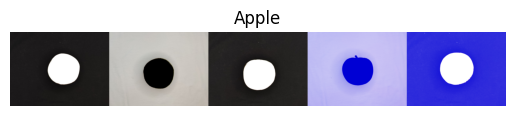

In [74]:
appleListGT = printImagesGT("fruitsDB/groundTruth/apple", "Apple", 1, 5)
bananaListGT = printImagesGT("/fruitsDB/groundTruth/banana", "Banana", 1, 5)
lemonListGT = printImagesGT("/fruitsDB/groundTruth/lemon", "Lemon", 1, 5)
strawberryListGT = printImagesGT("/fruitsDB/groundTruth/strawberry", "Strawberry", 1, 5)
tangerineListGT = printImagesGT("/fruitsDB/groundTruth/tangerine", "Tangerine", 1, 5)

In [ ]:
# PREPARING DATA
def prepareImages(directory, target, data):
  directory_path = directory
  directory_files = os.listdir(directory_path)
  directory_files.sort()
  #global data

  for file in directory_files:
    img = skimage.io.imread(directory_path + "/" + file)

    #img_gray = skimage.color.rgb2gray(img)
    data['images'].append(img)
    data["targets"].append(target)

  return data

In [ ]:
data = dict()
data['images'] = []
data['targets'] = []

target_names = ["Apple","Banana","Lemon", "Strawberry", "Tangerine"]

data = prepareImages("fruitsDB/dataAugmentation/apple", 0, data)
data = prepareImages("fruitsDB/dataAugmentation/banana", 1, data)
data = prepareImages("fruitsDB/dataAugmentation/lemon", 4, data)
data = prepareImages("fruitsDB/dataAugmentation/strawberry", 7, data)
data = prepareImages("fruitsDB/dataAugmentation/tangerine", 8, data)

In [ ]:
X = np.array(data['images'])
Y = np.array(data['targets'])

n_samples = len(X)
dataFinal = X.reshape((n_samples, -1)) # flatten the images

print(f'n_samples:{n_samples} data shape:{dataFinal.shape}')

n_samples:400 data shape:(400, 1440000)


In [ ]:
# SPLIT DATA
from sklearn.model_selection import train_test_split

# Split data into 80% train and 20% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    dataFinal, Y, test_size=0.2, shuffle=True
)

print(f'Train data -> type:{type(X_train)} shape:{X_train.shape} size:{X_train.size}\n')
print(f'Test data  -> type:{type(X_test)} shape:{X_test.shape} size:{X_test.size}\n')

Train data -> type:<class 'numpy.ndarray'> shape:(320, 1440000) size:460800000

Test data  -> type:<class 'numpy.ndarray'> shape:(80, 1440000) size:115200000



# Decision methods

In [ ]:
# N_Neighbor
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=1)

clf.fit(X_train, y_train)  # Learning

predicted = clf.predict(X_test)

In [ ]:
# SVC
from sklearn import svm

clf = svm.SVC()

clf.fit(X_train, y_train)

predicted = clf.predict(X_test)

In [ ]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(n_estimators=200, max_depth=50, random_state=0)

clf.fit(X_train, y_train)

predicted = clf.predict(X_test)

IndexError: list index out of range

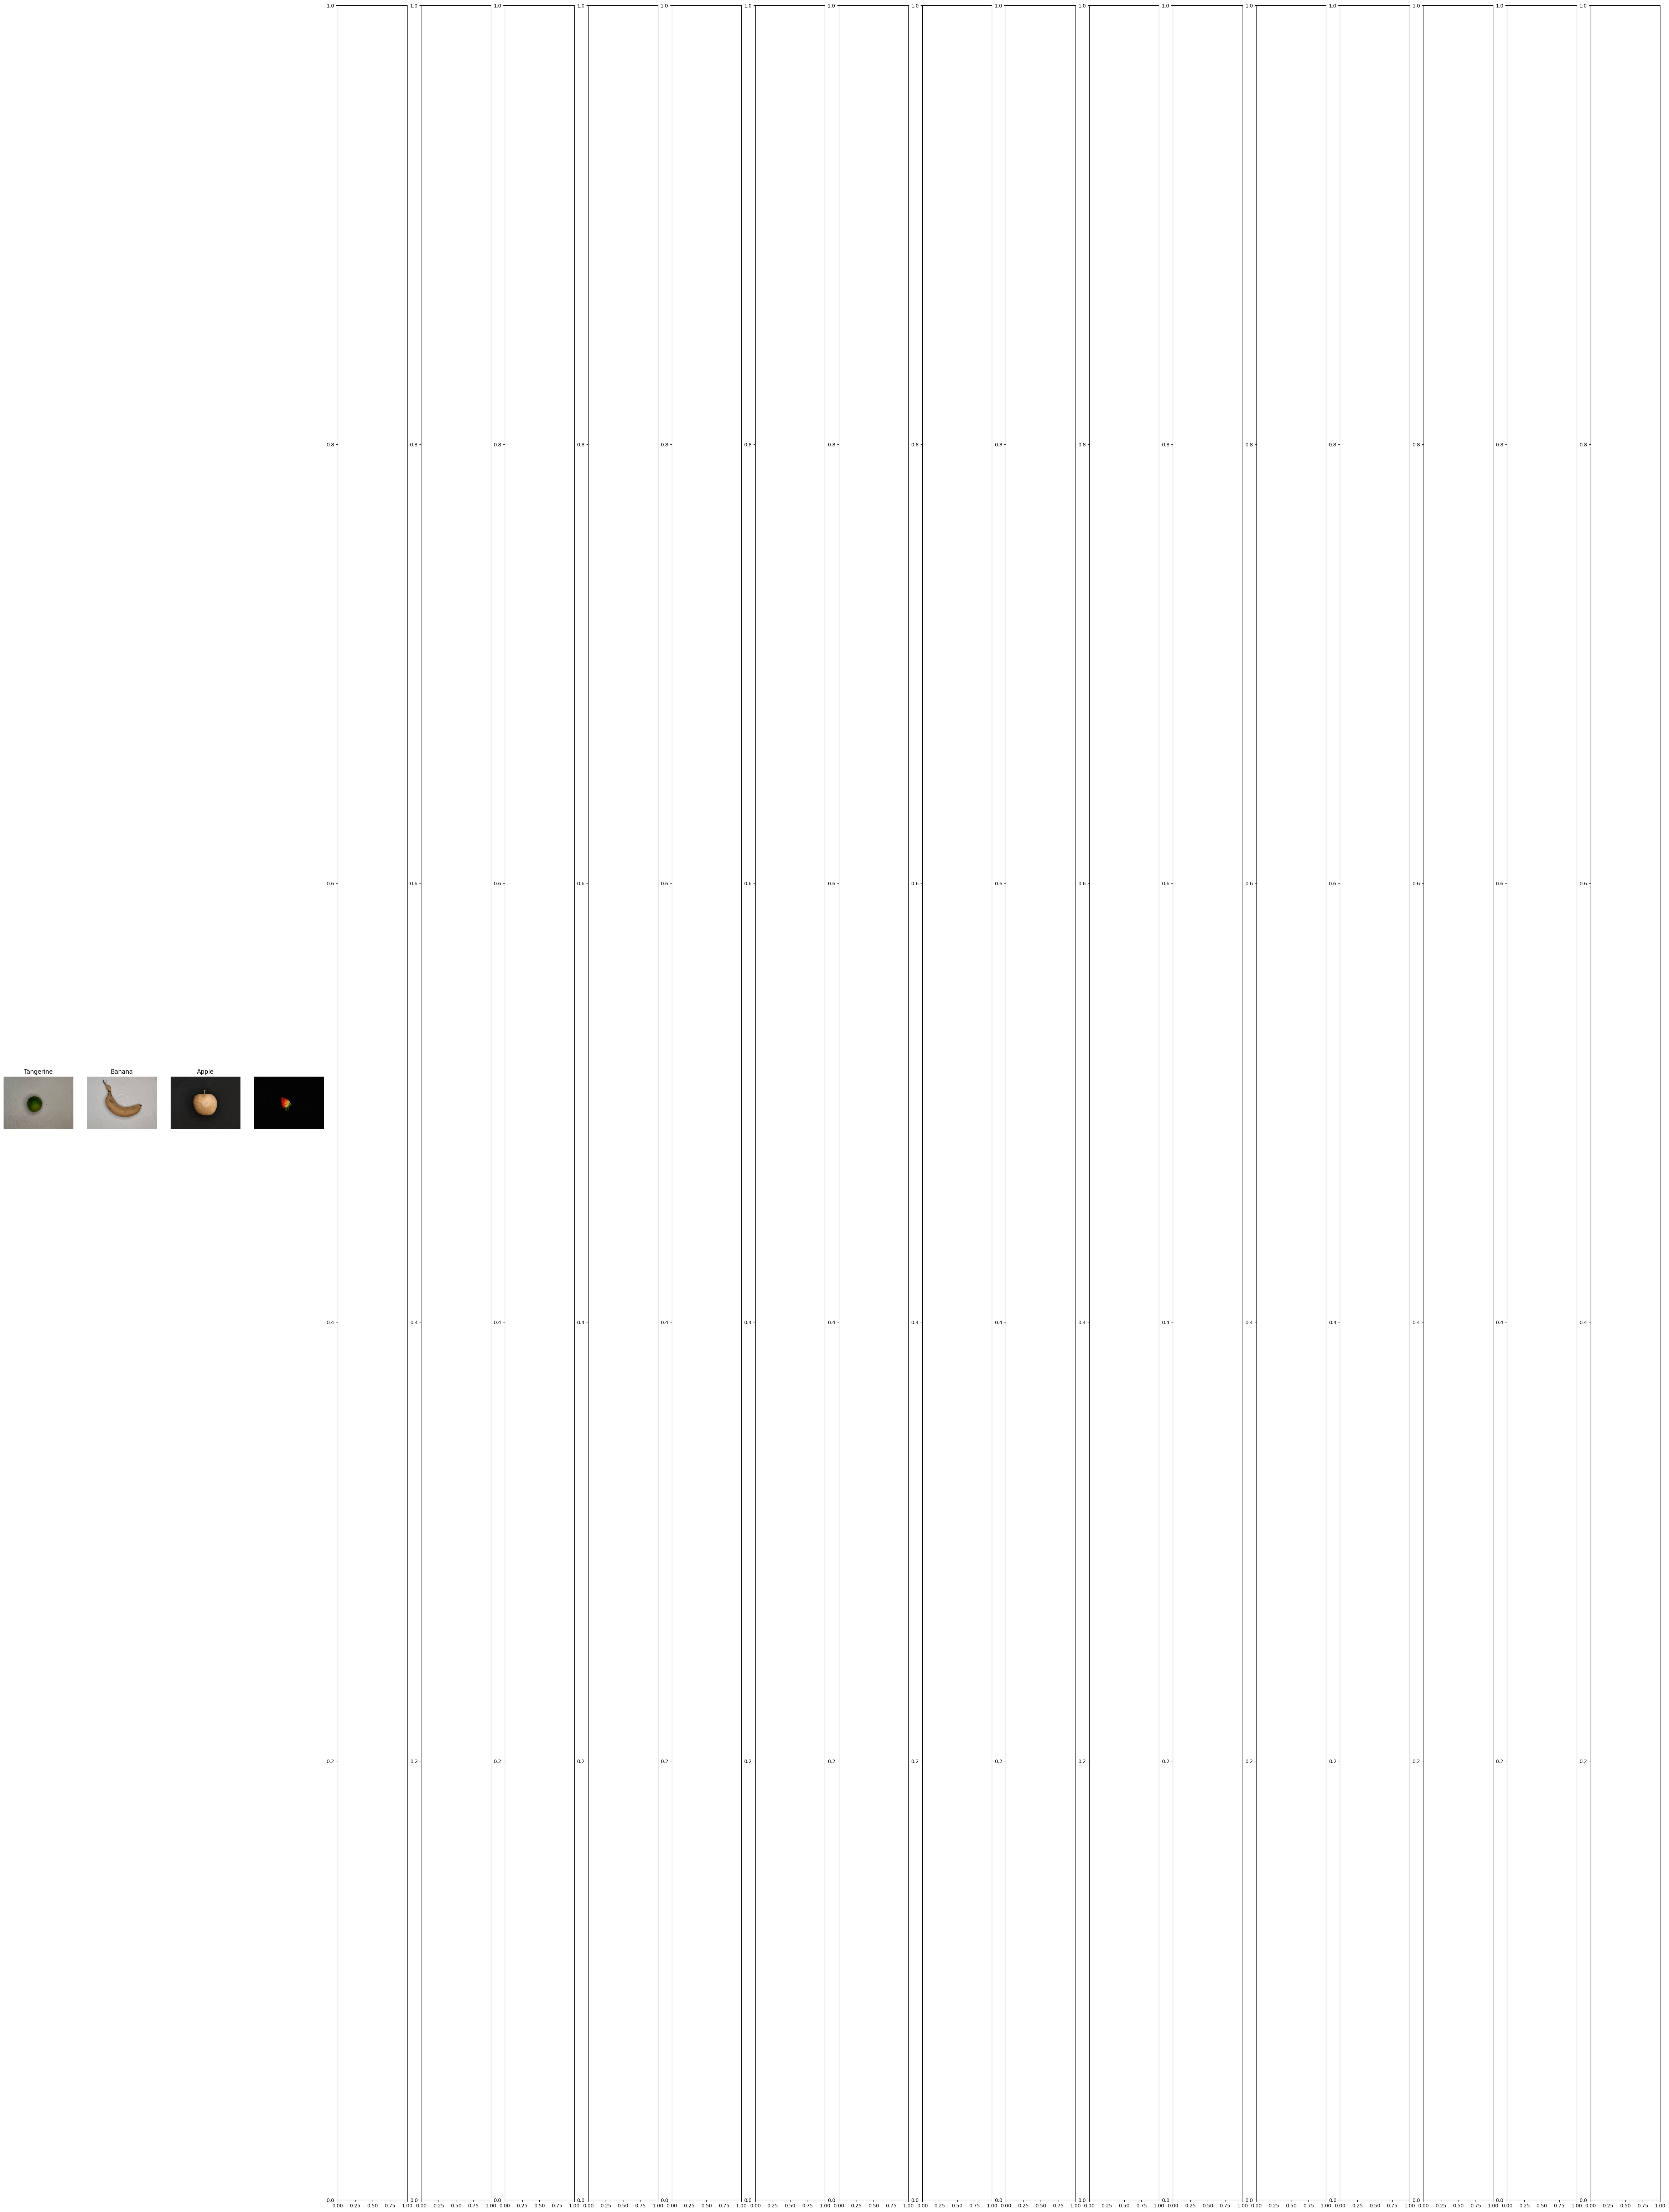

In [ ]:
# MOSTRANDO ALGUMAS PREDIÇÕES
_, axes = plt.subplots(nrows=1, ncols=20, figsize=(60, 80))

for ax, image, prediction in zip(axes, X_test, predicted):
    ax.set_axis_off()
    image = image.reshape(600, 800,3)
    ax.imshow(image, interpolation="nearest")
    ax.set_title(target_names[prediction])

# Métricas de classificação

Classification report for classifier SVC():
              precision    recall  f1-score   support

       Apple       1.00      0.94      0.97        18
      Banana       1.00      1.00      1.00        11
       Lemon       0.94      1.00      0.97        17
  Strawberry       1.00      1.00      1.00        14
   Tangerine       0.95      0.95      0.95        20

    accuracy                           0.97        80
   macro avg       0.98      0.98      0.98        80
weighted avg       0.98      0.97      0.97        80




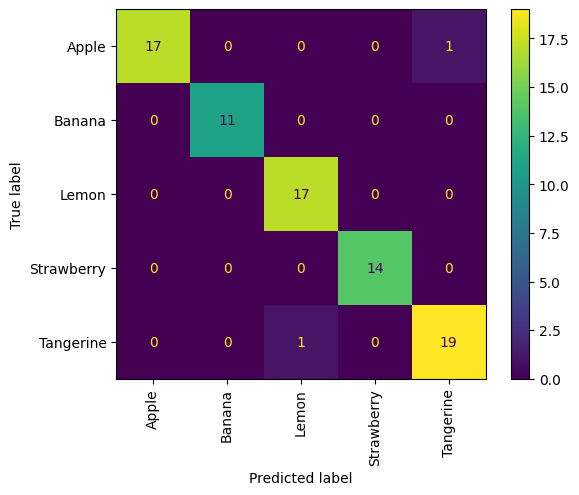

In [ ]:
# Metrics
from sklearn import metrics

print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted,target_names=target_names)}\n"
)

# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predicted)
cmd = ConfusionMatrixDisplay(cm, display_labels=target_names)

cmd.plot(xticks_rotation='vertical')